In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_mean_cluster_tos
from funzioni import plot_bias_2_models_atmos
from funzioni import plot_bias_2_models_tos
from funzioni import plot_std_cluster_atmos
from funzioni import plot_zonmean
from funzioni import plot_zonmean_2_cluster
from funzioni import plot_mean_cluster_zonmean
from funzioni import plot_std_cluster_tos
from funzioni import plot_std_cluster_zonmean
from funzioni import bs_sample_mean
from funzioni import bs_compute_array_mean_std_95cl
from funzioni import plot_bs_95cl_mean_std
from funzioni import bs_compute_matrix10
from funzioni import plot_bs_mean_cluster_matrix10
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle
import cartopy.crs as ccrs
import random

Caricamento file pickle

In [2]:
# Caricamento di models_atmos e models_zonmean
with open('models_atmos.pkl','rb') as file:
    models_atmos = dill.load(file)
    era_na_seas_mean = dill.load(file)
#with open('models_zonmean.pkl','rb') as file:
#    models_zonmean = dill.load(file)
#    era_seas_mean = dill.load(file)
with open('modelli_atmos.pickle', 'rb') as f:
    # Caricamento delle 5 liste contenenti i nomi dei modelli all'interno dei 5 cluster
    list_cluster0 = pickle.load(f)
    list_cluster1 = pickle.load(f)
    list_cluster2 = pickle.load(f)
    list_cluster3 = pickle.load(f)
    list_cluster4 = pickle.load(f)
    
    # Caricamento dei 5 cluster in formato pdf
    atmos_cluster0 = pickle.load(f)
    atmos_cluster1 = pickle.load(f)
    atmos_cluster2 = pickle.load(f)
    atmos_cluster3 = pickle.load(f)
    atmos_cluster4 = pickle.load(f)
    
    # Caricamento dei cluster medi in formato pdf
    atmos_cluster0_mean = pickle.load(f)
    atmos_cluster1_mean = pickle.load(f)
    atmos_cluster2_mean = pickle.load(f)
    atmos_cluster3_mean = pickle.load(f)
    atmos_cluster4_mean = pickle.load(f)

    #Caricamento dei cluster standard deviation in formato pdf
    atmos_cluster0_std = pickle.load(f)
    atmos_cluster1_std = pickle.load(f)
    atmos_cluster2_std = pickle.load(f)
    atmos_cluster3_std = pickle.load(f)
    atmos_cluster4_std = pickle.load(f)
# Caricamento di models_atmos e models_zonmean
with open('models_ua.pkl','rb') as file:
    models_ua = dill.load(file)
    era_ua_seas_mean= dill.load(file)
with open('models_ta.pkl','rb') as file:
    models_ta = dill.load(file)
    dataset_ERA_ta = dill.load(file)
    era_ta_seas_mean = dill.load(file)
    dict_egr_era = dill.load(file) #dizionario di ERA5_ta per il calcolo di egr

In [3]:
# Salvataggio in un file Pickle
with open('bootstrap_egr.pickle', 'rb') as f: #'rb' = read binary
    array_2th_cluster0 = pickle.load(f) #cluster0
    array_97th_cluster0 = pickle.load(f) #cluster0
    array_mean_cluster0= pickle.load(f) #cluster0
    array_std_cluster0 = pickle.load(f) #cluster0
    matrix10_cluster0 = pickle.load(f) #cluster0
    
    array_2th_cluster1 = pickle.load(f) #cluster1
    array_97th_cluster1 = pickle.load(f) #cluster1
    array_mean_cluster1= pickle.load(f) #cluster1
    array_std_cluster1 = pickle.load(f) #cluster1
    matrix10_cluster1 = pickle.load(f) #cluster1

    array_2th_cluster2 = pickle.load(f) #cluster2
    array_97th_cluster2 = pickle.load(f) #cluster2
    array_mean_cluster2= pickle.load(f) #cluster2
    array_std_cluster2 = pickle.load(f) #cluster2
    matrix10_cluster2 = pickle.load(f) #cluster2

    array_2th_cluster3 = pickle.load(f) #cluster3
    array_97th_cluster3 = pickle.load(f) #cluster3
    array_mean_cluster3= pickle.load(f) #cluster3
    array_std_cluster3 = pickle.load(f) #cluster3
    matrix10_cluster3 = pickle.load(f) #cluster3

    array_2th_cluster4 = pickle.load(f) #cluster4
    array_97th_cluster4 = pickle.load(f) #cluster4
    array_mean_cluster4= pickle.load(f) #cluster4
    array_std_cluster4 = pickle.load(f) #cluster4
    matrix10_cluster4 = pickle.load(f) #cluster4

Valore medio del cluster - array_mean (multi model mean)

In [11]:
#Funzione che calcola la media di un dataset xarray
def compute_mean_egr(name_list,name_dict):
    sum_bias = 0
    #calcolo il valor medio
    for i in range(len(name_list)):
        model_name = name_list[i]
        sum_bias = sum_bias + name_dict[model_name]['EGR seasonal mean DJF'][1] * 86400 #850hPa
    #valor medio
    mean_cluster0 = sum_bias / len(name_list)
    return mean_cluster0

In [12]:
#plot di diff, cioè la differenza tra il cluster medio e la media della distribuzione bootstrap --> in più ci metto anche i punti di significatività
def plot_bs_diff_cluster_egr(diff,title_plot,v_min,v_max,fig_size,matrix10): #name_models_to_plot indica la lista in cui sono racchiusi i nomi dei modelli da plottare, name_dict è o models_atmos
    fig, ax = plt.subplots(figsize=fig_size,subplot_kw={"projection": ccrs.PlateCarree()}) #trasformazione cartografica = lonxlat   
    plot_mod = ax.pcolormesh(diff.lon, diff.lat, diff,vmin=v_min, vmax=v_max,cmap='seismic') 
    coords = np.where(matrix10 == 1) #array di valori di longitudini e latitudini in cui matrix10 = 1
    # Plot dei punti solo dove matrix10 è uguale a 1
    ax.plot(diff.lon[coords[1]], diff.lat[coords[0]], marker='o', color='black', markersize=2, linestyle='None', transform=ccrs.PlateCarree())
    #imposto lat-lon sugli assi
    #valori assi            
    ax.set_xticks(np.arange(diff.lon.min(),diff.lon.max(), 20))
    ax.set_yticks(np.arange(diff.lat.min(),diff.lat.max(), 10))
    ax.coastlines() #gca = get current axis
    ax.set_ylabel('latitude')
    ax.set_xlabel('longitude')
    # Titolo
    fig.colorbar(plot_mod)
    fig.suptitle(title_plot, fontsize=16, y=1.02)

Cluster 0

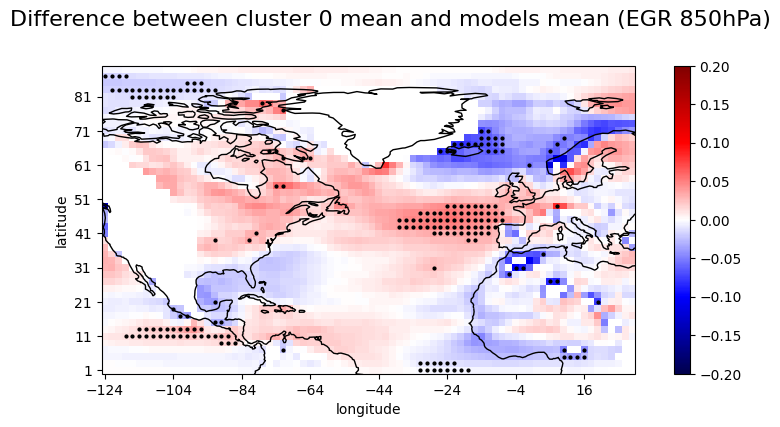

In [16]:
mean_cluster0 = compute_mean_egr(list_cluster0,models_ta)
diff_cluster0 = mean_cluster0 - array_mean_cluster0
plot_bs_diff_cluster_egr(diff_cluster0,'Difference between cluster 0 mean and models mean (EGR 850hPa)',-0.2,0.2,(10,4),matrix10_cluster0)

Cluster 1

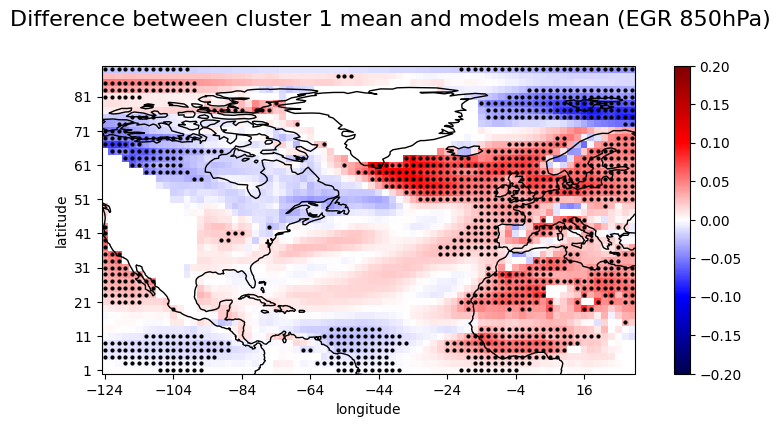

In [17]:
mean_cluster1 = compute_mean_egr(list_cluster1,models_ta)
diff_cluster1 = mean_cluster1 - array_mean_cluster1
plot_bs_diff_cluster_egr(diff_cluster1,'Difference between cluster 1 mean and models mean (EGR 850hPa)',-0.2,0.2,(10,4),matrix10_cluster1)

Cluster 2

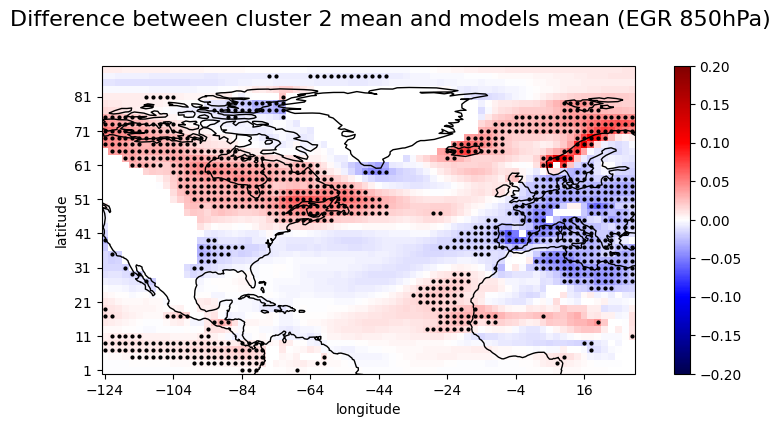

In [18]:
mean_cluster2 = compute_mean_egr(list_cluster2,models_ta)
diff_cluster2 = mean_cluster2 - array_mean_cluster2
plot_bs_diff_cluster_egr(diff_cluster2,'Difference between cluster 2 mean and models mean (EGR 850hPa)',-0.2,0.2,(10,4),matrix10_cluster2)

Cluster 3

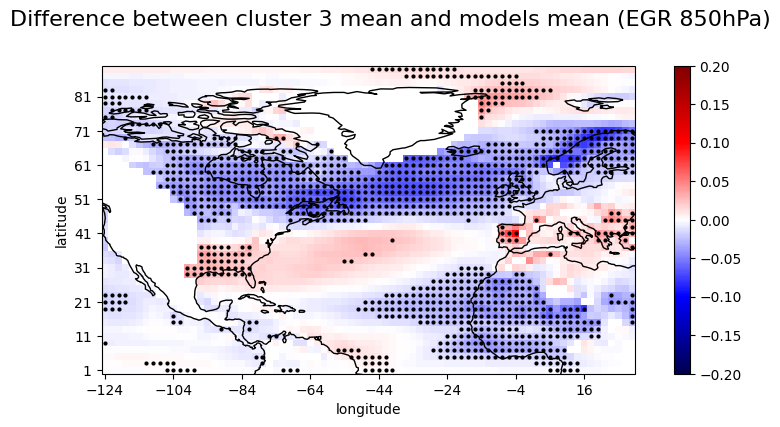

In [19]:
mean_cluster3 = compute_mean_egr(list_cluster3,models_ta)
diff_cluster3 = mean_cluster3 - array_mean_cluster3
plot_bs_diff_cluster_egr(diff_cluster3,'Difference between cluster 3 mean and models mean (EGR 850hPa)',-0.2,0.2,(10,4),matrix10_cluster3)

Cluster 4

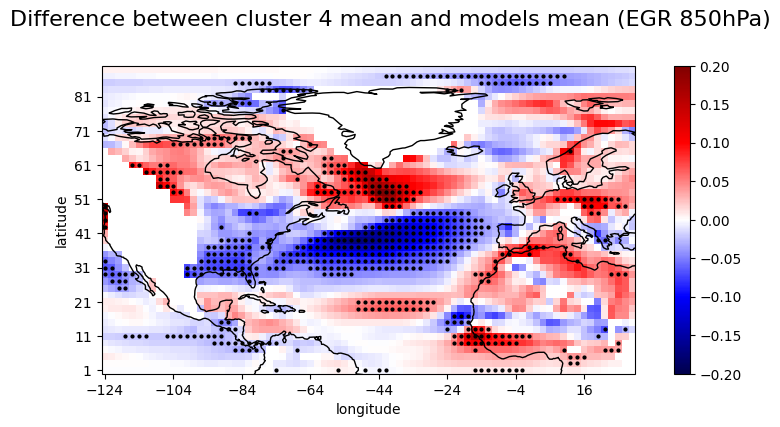

In [20]:
mean_cluster4 = compute_mean_egr(list_cluster4,models_ta)
diff_cluster4 = mean_cluster4 - array_mean_cluster4
plot_bs_diff_cluster_egr(diff_cluster4,'Difference between cluster 4 mean and models mean (EGR 850hPa)',-0.2,0.2,(10,4),matrix10_cluster4)